In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from dgl.data import DGLDataset
import dgl
import dgl.function as fn
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io

Using backend: pytorch


## Load and Normalize Data

In [2]:
train_layouts = 10000
test_layouts = 200

In [3]:
data = scipy.io.loadmat('cf_train_6_30.mat')
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)

In [4]:
test_data = scipy.io.loadmat('cf_test_6_30.mat')
beta_test = test_data['betas']
direct_test = test_data['directs']
cross_test = test_data['corsses'].transpose(0,2,1)

In [5]:
def normalize_data(train_data,test_data):
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    n1, n2 = norm_train.shape[0], norm_test.shape[0]
    return norm_train, norm_test
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )

## Create Dataset

In [6]:
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

#### Create DGL Dataset
The simplified message-passing scheme works on homogenous graph, so we follow https://docs.dgl.ai/guide/data.html

In [7]:
class PCDataset(DGLDataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype = torch.float)
        self.cross = torch.tensor(cross, dtype = torch.float)
        self.KM = KM
        self.get_cg()
        super().__init__(name='power_control')
        
        
    def build_graph(self, idx):
        H = np.expand_dims(self.norm_losses[idx,:,:].T, axis = -1)
        H_ones = 1/np.sqrt(self.KM[1]) * np.ones((self.KM[0], self.KM[1], 1))
        graph = dgl.graph(self.adj, num_nodes=self.KM[0])
        
        node_features = torch.tensor(np.concatenate((H, H_ones), axis = -1), dtype = torch.float)
        graph.ndata['feat'] = node_features
        return graph
    
    def get_cg(self):
        self.adj = []
        for i in range(0,self.KM[0]):
            for j in range(0,self.KM[0]):
                    self.adj.append([i,j])
                    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.direct)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.graph_list[index], self.direct[index], self.cross[index]

    def process(self):
        n = len(self.direct)
        self.graph_list = []
        for i in range(n):
            graph = self.build_graph(i)
            self.graph_list.append(graph)

In [8]:
# Please refer to https://docs.dgl.ai/en/0.2.x/tutorials/basics/4_batch.html for details of collate
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

In [9]:
train_data = PCDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

In [10]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, test_layouts, shuffle=False, collate_fn=collate)

## Build Graph Neural Networks

#### Define loss function
The loss function is similar to D2D case, differs in two aspects:
1. crosslink_channel_losses have diagonal part
2. Take minimum instead of sum

In [11]:
def rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.min(rates, dim = 1)[0]
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

#### Message Passing Modules
The message-passing involves two parts.

In 1st iteration, the message is passed from AP to UE. The function is AP2UE and is without DGL.

The remaining message-passing is only between users, which is similar to D2D and follows https://docs.dgl.ai/guide/message-api.html

In [12]:
def MLP(channels, batch_norm=True):
    if batch_norm:
        return Seq(*[
            Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
            for i in range(1, len(channels))
        ])
    else:
        return Seq(*[
            Seq(Lin(channels[i - 1], channels[i]), ReLU())
            for i in range(1, len(channels))
        ])

In [17]:
class AP2UE(nn.Module):
    def __init__(self, mlp, **kwargs):
        super(AP2UE, self).__init__()
        self.mlp = mlp
        #self.reset_parameters()
    
    def forward(self, g):
        g.ndata['feat'] = self.mlp(g.ndata['feat'])
        g.ndata['hid'] = torch.mean(g.ndata['feat'], axis = 1)

In [18]:
class EdgeConv(nn.Module):
    def __init__(self, mlp, **kwargs):
        super(EdgeConv, self).__init__()
        self.mlp = mlp
        #self.reset_parameters()

    def concat_message_function(self, edges):
        return {'out': torch.cat([edges.src['hid'], edges.dst['hid']], axis=1)}
    
    def forward(self, g):
        g.apply_edges(self.concat_message_function)
        g.edata['out'] = self.mlp(g.edata['out'])
        g.update_all(fn.copy_edge('out', 'm'),
                     fn.mean('m', 'hid'))

In [19]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.emb = AP2UE(MLP([2, 32], batch_norm=False))
        self.conv1 = EdgeConv(MLP([64, 32]))
        self.conv2 = EdgeConv(MLP([64, 32]))
        self.mlp = MLP([32, 16])
        self.mlp = Seq(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self, g):
        self.emb(g)
        self.conv1(g)
        self.conv2(g)
        out = self.mlp(g.ndata['hid'])
        return out

In [20]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

## Training and Test
The training is similar to the node regression task, please refer to https://docs.dgl.ai/en/0.6.x/guide/training-node.html for DGL node regression training

In [21]:
def train(epoch):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (g, d_train, c_train) in enumerate(train_loader):
        #data = data.to(device)
        K = d_train.shape[-1]
        n = len(g.ndata['feat'])
        bs = len(g.ndata['feat'])//K
        
        optimizer.zero_grad()
        output = model(g).reshape(bs,-1)
        loss = rate_loss(output, d_train, c_train)
        loss.backward()
        
        loss_all += loss.item() * bs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [22]:
def test(loader):
    model.eval()
    correct = 0
    for (g, d_test, c_test) in loader:
        K = d_test.shape[-1]
        n = len(g.ndata['feat'])
        bs = len(g.ndata['feat'])//K
        #data = data.to(device)
        output = model(g).reshape(bs,-1)
        loss = rate_loss(output, d_test, c_test)
        correct += loss.item() * bs
    return correct / len(loader.dataset)

In [23]:
record = []
for epoch in range(0, 50):
    if(epoch % 5 == 0):
        with torch.no_grad():
            train_rate = test(train_loader)
            test_rate = test(test_loader)
        print('Epoch {:03d}, Train Rate: {:.4f}, Test Rate: {:.4f}'.format(
            epoch, train_rate, test_rate))
        record.append([train_rate, test_rate])
    train(epoch)
    scheduler.step()

Epoch 000, Train Rate: -0.5384, Test Rate: -0.5186
Epoch 005, Train Rate: -1.0593, Test Rate: -1.0696
Epoch 010, Train Rate: -1.0648, Test Rate: -1.0785
Epoch 015, Train Rate: -1.0671, Test Rate: -1.0770
Epoch 020, Train Rate: -1.0655, Test Rate: -1.0739
Epoch 025, Train Rate: -1.0691, Test Rate: -1.0818
Epoch 030, Train Rate: -1.0591, Test Rate: -1.0650
Epoch 035, Train Rate: -1.0656, Test Rate: -1.0776
Epoch 040, Train Rate: -1.0700, Test Rate: -1.0810
Epoch 045, Train Rate: -1.0713, Test Rate: -1.0794


## Plot CDF

In [26]:
## For CDF Plot
import matplotlib.pyplot as plt
for (g, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(g.ndata['feat'])
    bs = len(g.ndata['feat'])//K
    output = model(g).reshape(bs,-1)
    gnn_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()
    full = torch.ones_like(output)
    all_one_rates = rate_loss(full, d_test, c_test, True).flatten().numpy()
    
## Load optimal resource allocation from .mat file
test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = test_data['R_cf_opt_min']

In [27]:
min_rate, max_rate = 0, 2
y_axis = np.arange(0, 1.0, 1/202)
gnn_rates.sort(); all_one_rates.sort(); opt_rates.sort()
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,201,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,201,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,201,max_rate)

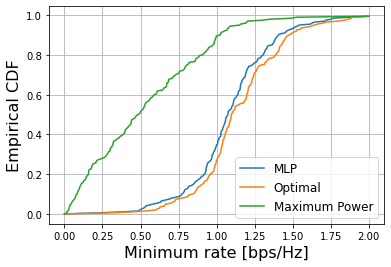

In [28]:
plt.plot(gnn_rates, y_axis, label = 'GNN')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()